<h1 align="center"><strong>Neural Style Transfer</strong></h1>
<h2 align="center">Audrey MAURETTE</h2>
<h3 align="center"><em>Janvier 2026<em></h3>



## **Références**

Article assigné :

[Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). *A Neural Algorithm of Artistic Style*. arXiv:1508.06576.](https://arxiv.org/pdf/1508.06576)


## **Chargement librairies**

In [73]:
import torch
from torch import nn, optim
import torchvision.models as models #modèles préentrainés de torchvision

from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt

import os

import time

In [74]:
current_dir = os.getcwd()

In [75]:
data_path = os.path.join(current_dir, "data")

# **Table des matières**

- [0. Notions utiles](#0-notions-utiles)
- [1. Chargement du modèle](#1-chargement-du-modèle)
- [2. Implémentation de la loss](#2-implémentation-de-la-loss)
  - [2.1 Perte de contenu](#21-perte-de-contenu-)
  - [2.2 Perte de style](#22-perte-de-style-)
- [3. Représentation des images](#3-représentation-des-images)
  - [3.1 Choix de l'mage de contenu](#31-choix-de-limage-de-contenu)
  - [3.2 Reconstitution de l'image de style](#32-reconstitution-de-limage-de-contenu)
  - [3.3 Choix de l'image de style](#33-choix-de-limage-de-style)
  - [3.4 Reconstitution du style d'une image](#34-reconstitution-du-style-dune-image)
- [4. Création d'image artistique](#4-création-dimage-artistique)
  - [4.1 Paramètres](#41-paramètres)
  - [4.2 Pipeline](#42-pipeline)
  - [4.3 Exemples de génération d'images](#43-exemples-de-génération)
- [5. AdaIN : Adaptive Instance Normalization](#5-adain--adaptive-instance-normalization)


## **0. Notions utiles**



- layer : couche d'un réseau de neurone
- feature : un filtre au sein d'une CONV layer




Chaque couche du réseau définit généralement une banque de filtres non-linéaires dont la complexité augmente avec la profondeur dans le réseau. Ainsi, une image d’entrée $\tilde{x}$ est encodée dans chaque couche du CNN par les réponses des filtres appliqués à cette image.  

Une couche avec $N_l$ filtres distincts possède $N_l$ **feature maps**, chacune de taille $M_l$, où $M_l$ correspond au produit de la hauteur et de la largeur de la **feature maps**.  

Les réponses de la couche $l$ peuvent donc être stockées dans une matrice $F^l \in \mathbb{R}^{N_l \times M_l}$, où $F^l_{ij}$ représente l’activation du $i$-ième filtre à la position $j$ dans la couche $l$.  

Pour visualiser l’information encodée à différents niveaux de la hiérarchie (Fig. 1, reconstructions de contenu), on effectue une descente de gradient sur une image de bruit blanc afin de trouver une autre image dont les réponses aux filtres correspondent à celles de l’image originale.


---

## **1. Chargement du modèle**

### **1.1 Chargement du modèle VGG préentrainé**

Le modèle va être utilisé comme extracteur de représentations visuelles.

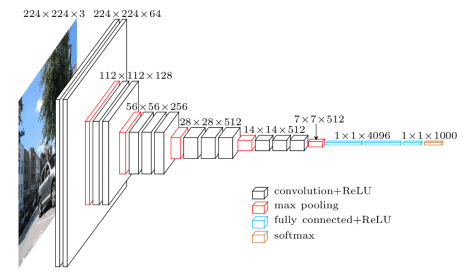

- L'extension __*.features*__ permet de récupérer les couches de __*convolution*__, __*ReLU*__ et __*pooling*__
- L'extension __*.classifier*__ permet de récupérer les couches __*full-connected*__. Celles-ci sont utiles pour la classification ce qui n'est pas l'objet de notre étude ici.

In [76]:
vgg = models.vgg19(pretrained=True).features #charge VGG-19 pré-entrainé sur ImageNet
vgg.eval() #met le modèle en mode évaluation --> désactive certains comportements spécifiques à l'entrainement (ex: dropout, batchnorm)


for param in vgg.parameters():
    param.requires_grad = False #empêche la mise à jour des poids du modèle durant l'entrainement

/home/audrey-maurette/anaconda3/envs/sdd_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/audrey-maurette/anaconda3/envs/sdd_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **1.2 Nomenclature complète de VGG19**

**Bloc 1:** 0 conv1_1 | 1 relu1_1 | 2 conv1_2 | 3 relu1_2 | 4 pool1  

**Bloc 2:** 5 conv2_1 | 6 relu2_1 | 7 conv2_2 | 8 relu2_2 | 9 pool2  

**Bloc 3:** 10 conv3_1 | 11 relu3_1 | 12 conv3_2 | 13 relu3_2 | 14 conv3_3 | 15 relu3_3 | 16 conv3_4 | 17 relu3_4 | 18 pool3  

**Bloc 4:** 19 conv4_1 | 20 relu4_1 | 21 conv4_2 | 22 relu4_2 | 23 conv4_3 | 24 relu4_3 | 25 conv4_4 | 26 relu4_4 | 27 pool4  

**Bloc 5:** 28 conv5_1 | 29 relu5_1 | 30 conv5_2 | 31 relu5_2 | 32 conv5_3 | 33 relu5_3 | 34 conv5_4 | 35 relu5_4 | 36 pool5


In [77]:
# Affiche toutes les couches avec leur type et index
for i, layer in enumerate(vgg):
    print(i, layer)


0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

**Fonctions pour récupérer le nom des couches du modèle**

In [78]:
def get_vgg_layer_names(vgg_model):
    names = {}
    conv_count = 0
    relu_count = 0
    pool_count = 0
    block = 1

    for i, layer in enumerate(vgg_model):
        if isinstance(layer, nn.Conv2d):
            conv_count += 1
            names[i] = f"conv{block}_{conv_count}"
        elif isinstance(layer, nn.ReLU):
            names[i] = f"relu{block}_{conv_count}"  # relu suit le conv
        elif isinstance(layer, nn.MaxPool2d):
            pool_count += 1
            names[i] = f"pool{block}"
            block += 1
            conv_count = 0  # reset count pour le bloc suivant
        else:
            names[i] = str(layer)
    return names


def print_layer_names(chosen_layers, layer_names):
    print("Couches choisies :")
    for idx in chosen_layers:
        name = layer_names.get(idx, "Unknown")
        print(f"Index {idx} : {name}")


layer_names = get_vgg_layer_names(vgg)
# for i, name in layer_names.items():
#     print(i, name)


### **1.3 Extracteur de features**

Les objets de classe **VGGFeatures** permettent d'extraire que certaines couches spécifiques du réseau VGG.

In [79]:
class VGGFeatures(torch.nn.Module):
    def __init__(self, vgg, layers):
        super().__init__()
        self.vgg = vgg
        self.layers = layers

    def forward(self, x):
        features = {}
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layers:
                features[i] = x
        return features

---

## **2. Implémentation de la loss**

### **2.1 Perte de contenu :**

Soient $\tilde{p}$ l’image originale et $\tilde{x}$ l’image générée, et soient $P^l$ et $F^l$ leurs représentations de caractéristiques respectives à la couche $l$. On définit alors la fonction de perte de contenu comme l’erreur quadratique entre ces deux représentations :

$$
\mathcal{L}_{\text{contenu}}(\tilde{p}, \tilde{x}, l)
= \frac{1}{2} \sum_{i,j} \left( F^l_{ij} - P^l_{ij} \right)^2.
$$





In [80]:
def content_loss(F, P):
    return torch.mean((F - P) ** 2)


### **2.2 Perte de style :**

**Définition de la matrice de Gram.**  
La matrice de Gram $G^l \in \mathbb{R}^{N_l \times N_l}$ est définie de telle sorte que chaque élément $G^l_{ij}$ correspond au produit scalaire entre les cartes de caractéristiques vectorisées $i$ et $j$ de la couche $l$ :

$$
G^l_{ij} = \sum_k F^l_{ik} \, F^l_{jk}.
$$



In [81]:
def gram_matrix(x):
    b, c, h, w = x.size() # b : nombre d'images dans le batch, c : nombre de canaux, h et w : hauteur et largeur des features maps,
    features = x.view(c, h * w) # aplatit les features maps en une matrice de taille (c, h*w)
    G = torch.mm(features, features.t()) # produit matriciel
    return G


Soient $\tilde{a}$ l’image de style originale et $\tilde{x}$ l’image générée, et soient $A^l$ et $G^l$ leurs représentations de style respectives à la couche $l$. La contribution de cette couche à la fonction de perte totale est définie par :

$$
E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} \left( G^l_{ij} - A^l_{ij} \right)^2.
$$

La fonction de perte de style totale est alors donnée par :

$$
\mathcal{L}_{\text{style}}(\tilde{a}, \tilde{x}) = \sum_{l=0}^{L} w_l \, E_l,
$$

où les coefficients $w_l$ pondèrent la contribution de chaque couche à la perte totale (voir ci-dessous pour les valeurs spécifiques de $w_l$ utilisées dans nos résultats).

In [82]:
def style_loss(gen_features, style_grams, style_layers, weights):

    loss = 0

    for i, l in enumerate(style_layers):
        # Gram matrix de l'image générée à la couche l
        G = gram_matrix(gen_features[l])
        A = style_grams[l]  # Gram matrix pré-calculée de l'image de style

        N = gen_features[l].size(1)   # nombre de canaux
        M = gen_features[l].size(2) * gen_features[l].size(3)  # h * w = nombre de pixels par canal

        E_l = torch.sum((G - A) ** 2) / (4 * (N ** 2) * (M ** 2))

        loss += weights[i] * E_l
    return loss

### **2.3 Perte de couleur** (non présenté dans l'article)


Pour préserver la palette globale de l’image de référence $\tilde{s}$, on définit une **perte de couleur** qui compare les moyennes des canaux de l’image générée $\tilde{x}$ et de l’image de référence $\tilde{s}$ :

$$
\mathcal{L}_{\text{color}}(\tilde{x}, \tilde{s}) = \frac{1}{C} \sum_{c=1}^{C} \left( \mu_c(\tilde{x}) - \mu_c(\tilde{s}) \right)^2,
$$

où $\mu_c(\tilde{x})$ est la moyenne du canal $c$ de l’image générée :

$$
\mu_c(\tilde{x}) = \frac{1}{H W} \sum_{h,w} \tilde{x}_{c,h,w}.
$$




In [83]:
def color_loss(gen, style):
    return torch.mean((gen.mean(dim=[2,3]) - style.mean(dim=[2,3]))**2)

---

## **3. Représentation des images**

### **3.0 Fonctions de chargement des images**

Les fonctions suivantes permettent d'upload les images et de les convertir au  bon format.

**Fonction load :**
- charge l'image, la redimensionne selon la taille voulue par l'utilisateur, et la transforme au bon format pour le modèle VGG

- Le **loader** convertit l'image en un tenseur PyTorch, et normalise l'image canal par canal avec les moyennes et écarts-types du dataset ImageNet

In [84]:
def load_image(img_name, max_size=None):
    """
    Charge l'image, la redimensionne si besoin,
    et la normalise pour VGG
    """

    img_path = os.path.join(data_path, img_name)
    img = Image.open(img_path).convert("RGB")

    # redimensionnement de l'image
    size = img.size  # (width, height)
    if max_size:
        ratio = max_size / max(size)
        new_size = (int(size[0] * ratio), int(size[1] * ratio))
        img = img.resize(new_size, Image.LANCZOS)

    # création du tensor normalisé
    loader = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ])

    img_loaded = loader(img).unsqueeze(0) # ajout d'une dimension batch 
    return img_loaded

**Fonction de dénormalisation**

In [85]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(tensor.device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(tensor.device)
    return tensor * std + mean

def tensor_to_image(tensor):
    img = tensor.detach().cpu().squeeze(0) # retirer batch
    img = img.permute(1,2,0) # (C,H,W) -> (H,W,C)
    img = (img - img.min()) / (img.max() - img.min()) # normaliser entre 0 et 1
    return img




**Fonction de passage du tenseur à l'image**

- Les premières images générées ont utilisé la version de la fonction commentée ci-dessous.

La fonction commentée ignorait la normalisation faite via le loader et ne rendait pas compte des couleurs intiales.

- La mise à jour permet de revenir à une image physique plus correcte 



In [86]:
# def tensor_to_image(tensor):
#     img = tensor.detach().cpu().squeeze(0) # retirer batch
#     img = img.permute(1,2,0) # (C,H,W) -> (H,W,C)
#     img = (img - img.min()) / (img.max() - img.min()) # normaliser entre 0 et 1
#     return img

def tensor_to_image(tensor):
    tensor = tensor.detach().cpu().squeeze(0) # coupe le tensor du graphe de calcul, le bascule sur CPU et retire la dimension batch
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) # pultiplication par l'écart-type
    tensor = tensor + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1) # ajout de la moyenne 
    tensor = tensor.clamp(0,1) # force les valeurs de pixels à être entre 0 et 1 pour avoir des valeurs réalistes 
    return transforms.ToPILImage()(tensor) # conversion en image PIL

**Fonction d'affichage de l'image**

In [87]:
def plot_image(img_loaded, title):

    print("Shape du tensor :", img_loaded.shape)
    if img_loaded.shape[1] != 3:
        print("Attention : l'image n'a pas 3 canaux !")
    else:
        print("Image OK : 3 canaux (RGB)")

    img_visu = denormalize(img_loaded)

    plt.figure(figsize=(10,5))
    plt.imshow(tensor_to_image(img_loaded))
    plt.title(title)
    plt.show()

### **3.1 Choix de l'image de contenu**

**Dans la cellule ci-dessous : choix de l'image dont on veut reconstituer le contenu + résolution souhaitée**

- **_Pour la démo, mettre résolution = 128 pour accélerer l'exécution (sinon 256 pour de meilleurs résultats)_**



Shape du tensor : torch.Size([1, 3, 96, 128])
Image OK : 3 canaux (RGB)


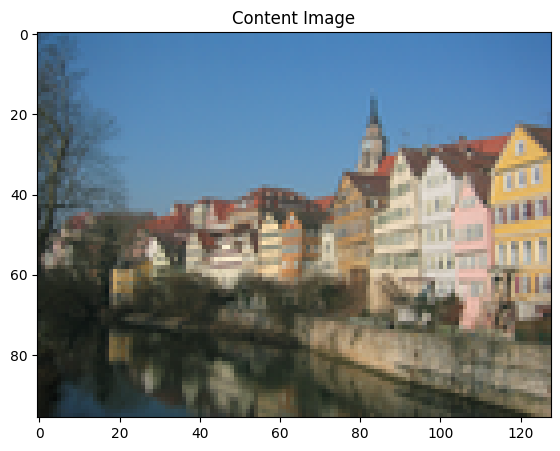

In [88]:
content_image = load_image("photo_facade.jpg", 128)

plot_image(content_image, "Content Image")


### **3.2 Reconstitution de l'image de contenu**


L'objectif de cette partie est de voir comment les différentes couches du réseau capturent le contenu d'une image.

Pour ça, on fait passer notre image de contenu $\tilde{p}$ dans le réseau et on récupère les activations d'une couche $l$ qui nous intéresse.  
Ces activations sont stockées dans la matrice $P^l$ (de taille $N_l \times M_l$), où $N_l$ est le nombre de filtres et $M_l$ le nombre de positions spatiales dans cette couche.

Ensuite, on part d'une image initialement bruitée $\tilde{x}$ et on la fait passer dans le réseau jusqu'à la même couche $l$.  

On met ensuite à jour l'image $\tilde{x}$ avec la **descente de gradient** pour minimiser la perte de contenu **(cf 2.1)**. 
 
À la fin, l'image générée ressemble aux activations de l'image de contenu pour la couche $l$, ce qui nous permet de **visualiser ce que la couche a “appris” du contenu**.



#### **3.2.1 Génération d'une image bruitée**

A partir de l'image de contenu, on génère une image bruitée qui va servir de point de départ pour la reconsitution de l'image couche par couche.

Shape du tensor : torch.Size([1, 3, 96, 128])
Image OK : 3 canaux (RGB)


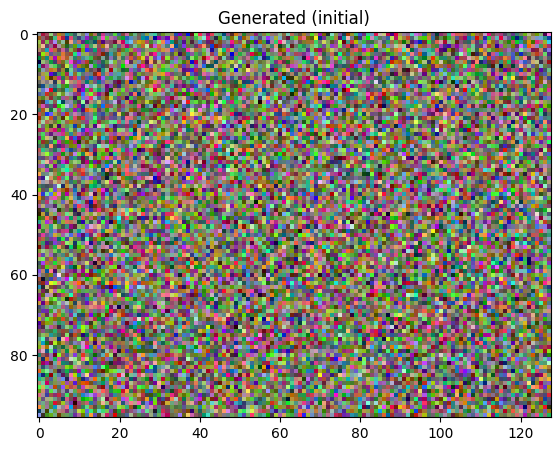

In [89]:
# génération de l'image de bruit : tenseur de la même forme que content_image
content_generated = torch.randn_like(content_image, requires_grad=True) # requires_grad = True pour que les gradients soient calculés pour cette
                                                                # -- variable durant la rétropropagation

plot_image(content_generated, "Generated (initial)")

#### **3.2.2 Choix des couches de contenu à analyser**

Il s'agit ici d'instancier un objet `VGGExtractor` (cf. [section 1.3 Extracteur de features](#13-extracteur-de-features)) afin d'indiquer quelles sont les couches du réseau pour lesquelles on souhaite observer les activations.


Index des couches de contenu utiles :

**Bloc 1:** 0 conv1_1 | 1 relu1_1

**Bloc 2:** 5 conv2_1 | 6 relu2_1

**Bloc 3:** 10 conv3_1 | 11 relu3_1

**Bloc 4:** 19 conv4_1 | 20 relu4_1

**Bloc 5:** 28 conv5_1 | 29 relu5_1

In [96]:
######### -------------------------------------- CHOIX COUCHE DE CONTENU  -------------------------------------- #########

content_layers = [10]

##########################################################################################################################

layer_idx = content_layers[0]

layer_name = layer_names[layer_idx]

print_layer_names(content_layers, layer_names)

Couches choisies :
Index 10 : conv3_1


In [97]:
#Instancier l'extracteur
content_extractor = VGGFeatures(vgg, layers=content_layers)

# activations (features maps) de l'image de contenu pour la couche liée à au content_extracteur
content_features = content_extractor(content_image)


#### **3.2.3 Optimisation de l'image bruitée**

En fonction de la couche choisie, l'optimiseur va minimiser la loss de la sortie de la couche choisie entre l'image de contenu et l'image bruitée

In [98]:
# création d'un optimiseur qui va modifier l'image générée (bruit)
content_optimizer = torch.optim.LBFGS([content_generated])

# variable de stockage de la loss à chaque itération
last_loss = None

# calcule la loss et les gradients pour l'image générée
def content_closure():
    
    global last_loss

    content_optimizer.zero_grad()
    gen_features = content_extractor(content_generated)

    loss_c = content_loss(gen_features[layer_idx],content_features[layer_idx])

    # ajout d'une loss de couleur pour préserver la teinte de l'image
    λ_color = 1e-2
    loss_c = loss_c + λ_color * color_loss(content_generated, content_image)

    loss_c.backward() # remplit content_generated.grad : gradients qui indiquent dans quelle direction chaque pixel doit être modifié

    last_loss = loss_c.item() # stockage de la loss

    return loss_c

**Paramètres de la boucle d'optimisation**

In [99]:
######### -------------------------------------- CHOIX PARAMETRES  ---------------------------------------------------- #########

num_steps = 20
display_steps = [1, 5, 20] # itérations pour lesquelles on souhaite afficher l'image générée
loss_threshold = 1e-2  # arrêt de la boucle si la loss est inférieure à ce seuil

################################################################################################################################

**Temps d'exécution total sans changement des paramètres : moins d'une minute avec CPU**

Step 1/20 | Loss: 2.066423 | Temps total: 0.10 min


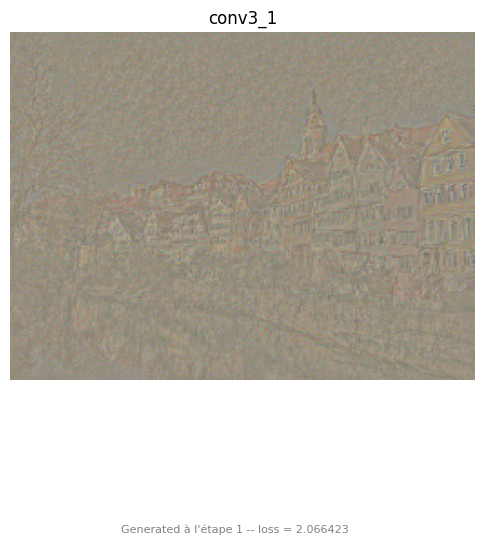

Step 2/20 | Loss: 0.961702 | Temps total: 0.21 min
Step 3/20 | Loss: 0.633472 | Temps total: 0.33 min
Step 4/20 | Loss: 0.482130 | Temps total: 0.46 min
Step 5/20 | Loss: 0.396211 | Temps total: 0.59 min


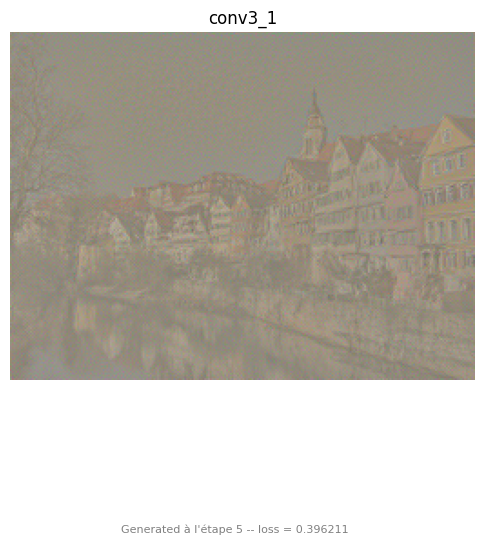

Step 6/20 | Loss: 0.338869 | Temps total: 0.71 min
Step 7/20 | Loss: 0.296486 | Temps total: 0.85 min
Step 8/20 | Loss: 0.264387 | Temps total: 0.97 min
Step 9/20 | Loss: 0.239045 | Temps total: 1.09 min


KeyboardInterrupt: 

In [100]:
start_total = time.time()

for i in range(num_steps):

    content_optimizer.step(content_closure)

    elapsed_total = time.time() - start_total

    print(f"Step {i+1}/{num_steps} | "f"Loss: {last_loss:.6f} | "f"Temps total: {elapsed_total/60:.2f} min")

    if (i + 1) in display_steps:

        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(denormalize(content_generated)))
        plt.axis('off')
        plt.title(layer_name)
        plt.figtext(0.5, -0.05, f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}", ha="center", fontsize=8, color="gray")


        plt.show()

    if last_loss is not None and last_loss < loss_threshold:
        print(f"Loss < {loss_threshold}, arrêt anticipé à l'étape {i+1}")

        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(denormalize(content_generated)))
        plt.axis('off')
        plt.title(layer_name)
        plt.figtext(0.5, -0.05, f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}", ha="center", fontsize=8, color="gray")

        plt.show()
        break


#### **BOUCLE CONTENT AUTOMATISEE**

Pour générer et enregistrer les résultats 

In [101]:

# content_image = load_image("photo_facade.jpg", 256)

# plot_image(content_image, "Content Image")

# base_output_dir = os.path.join(current_dir, "output_contenu")
# os.makedirs(base_output_dir, exist_ok=True)

# # content_layers = [[0], [5], [10], [19], [28]]
# content_layers = [[0], [5], [10], [19]]

# num_steps = 50 
# # display_steps = [1, 10, 50, 75, 100, 200, 300, 400, 500]*
# display_steps = [1, 10, 50]
# loss_threshold = 1e-3


# def color_loss(gen, style):
#     return torch.mean((gen.mean(dim=[2,3]) - style.mean(dim=[2,3]))**2)

# for layer in content_layers:

#     layer_idx = layer[0]
#     layer_name = layer_names[layer_idx]

#     print(" %%%%% Starting layer ", layer_name, " %%%%%%")

#     # dossier spécifique à la couche
#     layer_output_dir = os.path.join(base_output_dir, layer_name)
#     os.makedirs(layer_output_dir, exist_ok=True)

#     content_generated = torch.randn_like(content_image, requires_grad=True)

#     # # Génération d'une image de départ légèrement bruitée
#     # noise_level = 0.5  # ajustable : 0.01 à 0.1 selon l'effet désiré
#     # content_generated = content_image.clone() + noise_level * torch.randn_like(content_image)
#     # #content_generated = content_generated.clamp(0,1)  # optionnel : pour rester dans [0,1]
#     # content_generated.requires_grad_(True)

#     plot_image(content_generated, "Content Image")


#     content_extractor = VGGFeatures(vgg, layers=layer)
#     content_features = content_extractor(content_image)

#     content_optimizer = torch.optim.LBFGS([content_generated])

#     last_loss = None

#     def content_closure():
#         global last_loss

#         content_optimizer.zero_grad()
#         gen_features = content_extractor(content_generated)

#         loss_c = content_loss(
#             gen_features[layer_idx],
#             content_features[layer_idx]
#         )


#         λ_color = 1e-2
#         loss_c = loss_c + λ_color * color_loss(content_generated, content_image)

#         loss_c.backward()
#         last_loss = loss_c.item()

#         return loss_c

#     start_total = time.time()

#     for i in range(num_steps):

#         content_optimizer.step(content_closure)

#         elapsed_total = time.time() - start_total

#         print(
#             f"Step {i+1}/{num_steps} | "
#             f"Loss: {last_loss:.6f} | "
#             f"Temps total: {elapsed_total/60:.2f} min"
#         )

#         if (i + 1) in display_steps:

#             plt.figure(figsize=(6,6))
#             plt.imshow(tensor_to_image(denormalize(content_generated)))
#             plt.axis('off')
#             plt.title(layer_name)
#             plt.figtext(
#                 0.5, -0.05,
#                 f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}",
#                 ha="center", fontsize=8, color="gray"
#             )

#             # sauvegarde de l'image
#             filename = f"{layer_name}_etape{i+1:03d}.png"
#             filepath = os.path.join(layer_output_dir, filename)
#             plt.savefig(filepath, bbox_inches="tight", dpi=150)

#             plt.show()

#         if last_loss is not None and last_loss < loss_threshold:
#             print(f"Loss < {loss_threshold}, arrêt anticipé à l'étape {i+1}")

#             plt.figure(figsize=(6,6))
#             plt.imshow(tensor_to_image(denormalize(content_generated)))
#             plt.axis('off')
#             plt.title(layer_name)
#             plt.figtext(
#                 0.5, -0.05,
#                 f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}",
#                 ha="center", fontsize=8, color="gray"
#             )

#             filename = f"{layer_name}_etape{i+1:03d}.png"
#             filepath = os.path.join(layer_output_dir, filename)
#             plt.savefig(filepath, bbox_inches="tight", dpi=150)

#             plt.show()
#             break


### **3.3 Choix de l'image de style**

**Dans la cellule ci-dessous : choix de l'image dont on veut reconstituer le style + résolution souhaitée**

- **_Pour la démo, mettre résolution = 128 pour accélerer l'exécution (sinon 256 pour de meilleurs résultats)_**



Shape du tensor : torch.Size([1, 3, 96, 128])
Image OK : 3 canaux (RGB)


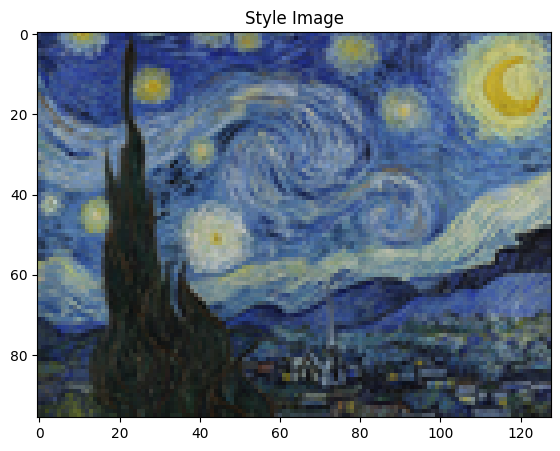

In [113]:

style_image = load_image("nuit_etoilee.jpg", 128)

plot_image(style_image, "Style Image")


### **3.4 Reconstitution du style d'une image**

L'objectif de cette partie est de voir comment les différentes couches du réseau capturent le **style** d'une image.

Le principe est similaire à celui de la partie 3.2 sur le contenu, mais cette fois-ci on s'intéresse à la **perte de style** plutôt qu'à la perte de contenu.

Pour chaque couche $l$, on calcule la **matrice de Gram** $G^l$ à partir des activations de l'image de style $\tilde{a}$.  
Cette matrice capture les corrélations entre les différentes cartes de caractéristiques (feature maps) de la couche $l$ :

$$
G^l_{ij} = \sum_k F^l_{ik} F^l_{jk},
$$

où $F^l$ représente les activations de l'image de style à la couche $l$.  

On initialise ensuite une image $\tilde{x}$ (souvent bruitée) et on fait passer cette image dans le réseau.  
La **perte de style** pour la couche $l$ est définie comme l'erreur quadratique entre la matrice de Gram de l'image générée et celle de l'image de style :

$$
E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} \left( G^l_{ij} - A^l_{ij} \right)^2,
$$

où $A^l$ est la matrice de Gram de l'image de style et $N_l, M_l$ sont respectivement le nombre de filtres et de positions spatiales dans la couche $l$.  

La **perte de style totale** sur toutes les couches choisies est alors :

$$
\mathcal{L}_{\text{style}}(\tilde{a}, \tilde{x}) = \sum_l w_l E_l,
$$

avec $w_l$ des coefficients de pondération pour chaque couche.  

On met ensuite à jour l'image $\tilde{x}$ par **descente de gradient** pour minimiser cette perte.  
À la fin, l'image générée reproduit le **style** de l'image originale tout en gardant son propre contenu.



#### **3.4.1 Génération d'une image bruitée**

Shape du tensor : torch.Size([1, 3, 96, 128])
Image OK : 3 canaux (RGB)


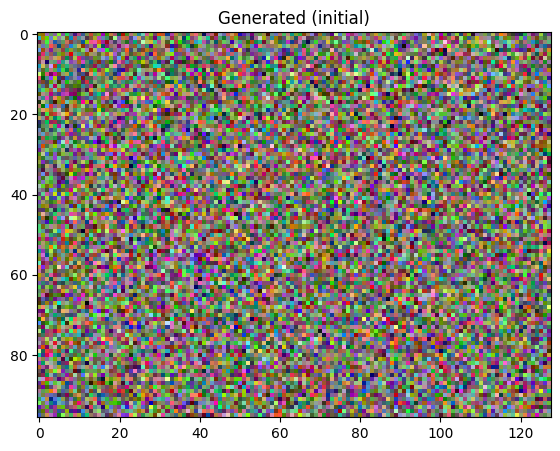

In [114]:
# génération de l'image de bruit : tenseur de la même forme que content_image
style_generated = torch.randn_like(style_image, requires_grad=True) # requires_grad = True pour que les gradients soient calculés pour cette
                                                                # -- variable durant la rétropropagation

plot_image(style_generated, "Generated (initial)")

#### **3.4.2 Choix des couches de style à analyser**

Il s'agit ici d'instancier un objet VGGExtractor (cf. section 1.3 Extracteur de features) afin d'indiquer quelles sont les couches du réseau pour lesquelles on souhaite observer les activations.

In [115]:
######### ------------------------------------ CHOIX COUCHES DE STYLE -------------------------------------------------- #########

style_layers = [0,5,10,19,28]
weights = [0.2, 0.2, 0.2, 0.2, 0.2] # poids pour pondérer l'impact de chaque couche choisie

#################################################################################################################################

print_layer_names(style_layers, layer_names)

Couches choisies :
Index 0 : conv1_1
Index 5 : conv2_1
Index 10 : conv3_1
Index 19 : conv4_1
Index 28 : conv5_1


Index des couches de style utiles :

**Bloc 1:** 0 conv1_1 | 1 relu1_1

**Bloc 2:** 5 conv2_1 | 6 relu2_1

**Bloc 3:** 10 conv3_1 | 11 relu3_1

**Bloc 4:** 19 conv4_1 | 20 relu4_1

**Bloc 5:** 28 conv5_1 | 29 relu5_1

In [116]:
# Instancier l'extracteur
style_extractor = VGGFeatures(vgg, layers=style_layers)

# activations (features maps) de l'image de style pour la couche liée à au style_extracteur
style_features = style_extractor(style_image)

# Calcul les Gram Matrix pour chaque couche de style
style_grams = {l: gram_matrix(style_features[l]) for l in style_layers}

#### **3.2.3 Optimisation de l'image bruitée**

En fonction de la couche choisie, l'optimiseur va minimiser la loss de la sortie de la couche choisie entre l'image de contenu et l'image bruitée

In [117]:
# création d'un optimiseur qui va modifier l'image générée (bruit)
style_optimizer = torch.optim.LBFGS([style_generated])

# variable de stockage de la loss à chaque itération
last_loss = None

#calcule la loss et les gradients pour l'image générée
def style_closure():
    global last_loss

    style_optimizer.zero_grad()

    gen_features = style_extractor(style_generated)

    loss_s = style_loss(gen_features, style_grams, style_layers, weights)

    # ajout loss de couleur 
    λ_color = 1e-2
    loss_s = loss_s + λ_color * color_loss(style_generated, style_image)


    loss_s.backward() # remplit style_generated.grad : gradients qui indiquent dans quelle direction chaque pixel doit être modifié

    last_loss = loss_s.item() # stockage de la loss

    return loss_s


In [119]:
######### -------------------------------------- CHOIX PARAMETRES  ---------------------------------------------------- #########

num_steps = 20
display_steps = [1, 5, 20]
loss_threshold = 1e-3 

#################################################################################################################################

**Temps d'exécution de la cellule sans changements de paramètres avec CPU : moins de 2 minutes**

Step 1/20 | Loss: 0.434472 | Temps total: 0.05 min


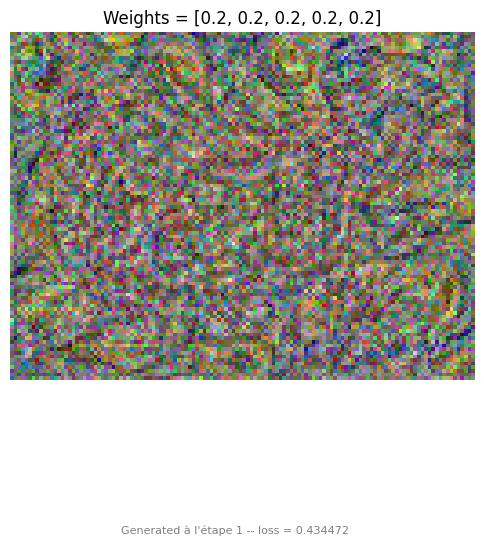

Step 2/20 | Loss: 0.232166 | Temps total: 0.11 min
Step 3/20 | Loss: 0.171369 | Temps total: 0.16 min
Step 4/20 | Loss: 0.142872 | Temps total: 0.21 min
Step 5/20 | Loss: 0.124431 | Temps total: 0.27 min


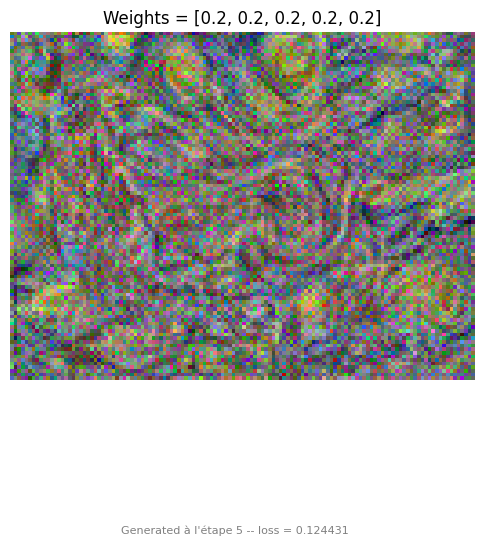

Step 6/20 | Loss: 0.111813 | Temps total: 0.33 min
Step 7/20 | Loss: 0.103077 | Temps total: 0.39 min
Step 8/20 | Loss: 0.095777 | Temps total: 0.45 min
Step 9/20 | Loss: 0.089745 | Temps total: 0.51 min
Step 10/20 | Loss: 0.085069 | Temps total: 0.56 min
Step 11/20 | Loss: 0.081050 | Temps total: 0.62 min
Step 12/20 | Loss: 0.077640 | Temps total: 0.69 min
Step 13/20 | Loss: 0.074927 | Temps total: 0.74 min
Step 14/20 | Loss: 0.072401 | Temps total: 0.80 min
Step 15/20 | Loss: 0.070202 | Temps total: 0.85 min
Step 16/20 | Loss: 0.068145 | Temps total: 0.89 min
Step 17/20 | Loss: 0.066393 | Temps total: 0.95 min
Step 18/20 | Loss: 0.064685 | Temps total: 1.00 min
Step 19/20 | Loss: 0.063063 | Temps total: 1.05 min
Step 20/20 | Loss: 0.061465 | Temps total: 1.10 min


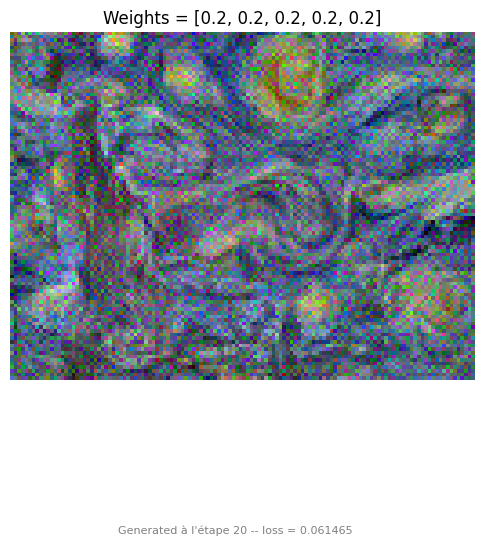

In [120]:

start_total = time.time()

for i in range(num_steps):

    style_optimizer.step(style_closure) # mise à jour du tenseur style_generated

    elapsed_total = time.time() - start_total

    print(
        f"Step {i+1}/{num_steps} | "
        f"Loss: {last_loss:.6f} | "
        f"Temps total: {elapsed_total/60:.2f} min"
    )

    if (i + 1) in display_steps:
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(style_generated))
        plt.axis('off')
        
        plt.title(f"Weights = {weights}")

        plt.figtext(0.5, -0.05,f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}",ha="center", fontsize=8, color="gray")

        plt.show()

    # Stop si la loss est déjà très faible
    if last_loss is not None and last_loss < loss_threshold:
        print(f"Loss < {loss_threshold}, arrêt anticipé à l'étape {i+1}")
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(style_generated))
        plt.axis('off')

        plt.title(f"Weights = {weights}")

        plt.figtext(0.5, -0.05,f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}",ha="center", fontsize=8, color="gray")
        plt.show()
        break


#### **BOUCLE AUTOMATISATION STYLE**

Pour générer et enregistrer résultats

In [121]:

# style_image = load_image("nuit_etoilee.jpg", 256)

# plot_image(style_image, "Style Image")


# base_output_dir = os.path.join(current_dir, "output_style")
# os.makedirs(base_output_dir, exist_ok=True)

# style_layers = [0, 5, 10, 19, 28]

# # weights_0 = [1, 0, 0, 0, 0]
# # weights_1 = [1/2, 1/2, 0, 0, 0]
# # weights_2 = [1/3, 1/3, 1/3, 0, 0]
# # weights_3 = [1/4, 1/4, 1/4, 1/4, 0]
# # weights_4 = [0.2, 0.2, 0.2, 0.2, 0.2]

# weights_0 = [1, 0, 0, 0, 0]
# weights_1 = [0, 1, 0, 0, 0]
# weights_2 = [0, 0, 1, 0, 0]
# weights_3 = [0, 0, 0, 1, 0]
# weights_4 = [0, 0, 0, 0, 1]


# weights_list = [weights_1, weights_2, weights_3, weights_4]


# num_steps = 100
# #display_steps = [1, 10, 50, 75, 100, 150, 200, 300, 400, 500]
# display_steps = [1, 10, 50, 100]
# loss_threshold = 1e-3


# def color_loss(gen, style):
#     return torch.mean((gen.mean(dim=[2,3]) - style.mean(dim=[2,3]))**2)


# for w_idx, weights in enumerate(weights_list):

#     weights_name = f"weights{w_idx}"
#     print(" %%%%% Starting ", weights_name, weights, " %%%%%%")

#     # dossier pour ce jeu de poids
#     weights_output_dir = os.path.join(base_output_dir, weights_name)
#     os.makedirs(weights_output_dir, exist_ok=True)


#     #image générée
#     style_generated = torch.randn_like(style_image, requires_grad=True)


#     # alpha = 0.2  # 0.1–0.3 en général
#     # style_generated = alpha * torch.randn_like(style_image) + (1 - alpha) * style_image
#     # style_generated.requires_grad_(True)


#     plot_image(style_generated, "Image générée initiale")

#     style_extractor = VGGFeatures(vgg, layers=style_layers)
#     style_features = style_extractor(style_image)

#     # Gram matrices du style
#     style_grams = {l: gram_matrix(style_features[l]) for l in style_layers}

#     style_optimizer = torch.optim.LBFGS([style_generated])

#     last_loss = None

#     def style_closure():
#         global last_loss

#         style_optimizer.zero_grad()
#         gen_features = style_extractor(style_generated)

#         loss_s = style_loss(
#             gen_features,
#             style_grams,
#             style_layers,
#             weights
#         )

#         λ_color = 1e-2
#         loss_s = loss_s + λ_color * color_loss(style_generated, style_image)


#         loss_s.backward()
#         last_loss = loss_s.item()

#         return loss_s

#     start_total = time.time()

#     for i in range(num_steps):

#         style_optimizer.step(style_closure)

#         elapsed_total = time.time() - start_total

#         print(
#             f"Step {i+1}/{num_steps} | "
#             f"Loss: {last_loss:.6f} | "
#             f"Temps total: {elapsed_total/60:.2f} min"
#         )

#         if (i + 1) in display_steps:

#             plt.figure(figsize=(6,6))
#             plt.imshow(tensor_to_image(style_generated))
#             plt.axis('off')

#             title_str = ", ".join([f"{w:.2f}" for w in weights])
#             plt.title(title_str)

#             plt.figtext(
#                 0.5, -0.05,
#                 f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}",
#                 ha="center", fontsize=8, color="gray"
#             )

#             # sauvegarde
#             filename = f"{weights_name}_etape{i+1:03d}.png"
#             filepath = os.path.join(weights_output_dir, filename)
#             plt.savefig(filepath, bbox_inches="tight", dpi=150)

#             plt.show()

#         if last_loss is not None and last_loss < loss_threshold:
#             print(f"Loss < {loss_threshold}, arrêt anticipé à l'étape {i+1}")

#             plt.figure(figsize=(6,6))
#             plt.imshow(tensor_to_image(style_generated))
#             plt.axis('off')

#             title_str = ", ".join([f"{w:.2f}" for w in weights])
#             plt.title(title_str)

#             plt.figtext(
#                 0.5, -0.05,
#                 f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}",
#                 ha="center", fontsize=8, color="gray"
#             )

#             filename = f"{weights_name}_etape{i+1:03d}.png"
#             filepath = os.path.join(weights_output_dir, filename)
#             plt.savefig(filepath, bbox_inches="tight", dpi=150)

#             plt.show()
#             break


## **4. Création d'image artistique**

Dans cette section on reprend la démarche de 3.2 et 3.4 pour créer une image artistique à partir du contenu d'une première image et du style d'une seconde image.


Ici la **loss totale** que la boucle d'optimisation va viser à minimiser est donnée par :

$$
\text{Loss Totale} = L_{\text{content}} + L_{\text{style}}
$$


### **4.1 Paramètres**

Shape du tensor : torch.Size([1, 3, 192, 256])
Image OK : 3 canaux (RGB)


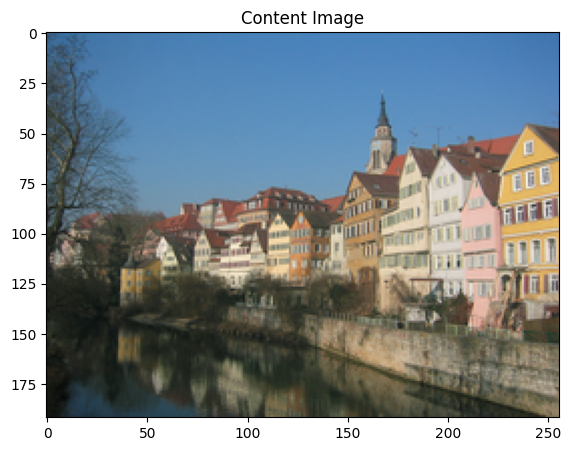

Shape du tensor : torch.Size([1, 3, 192, 256])
Image OK : 3 canaux (RGB)


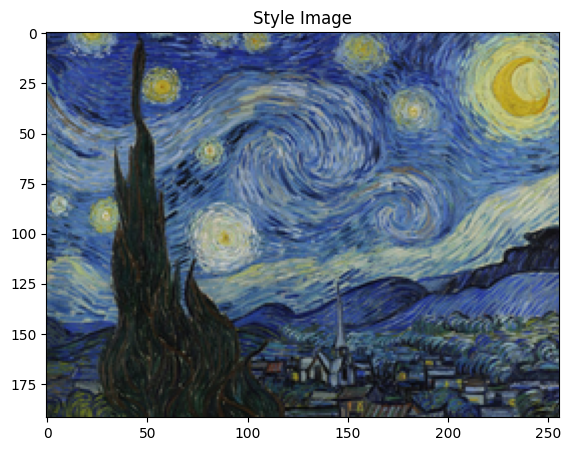

In [ ]:
###### ----------------------------------------------- PARAMETRES ----------------------------------------------- ######

###### ------ Choix des images 

content_image = load_image("photo_facade.jpg", 256)
style_image = load_image("nuit_etoilee.jpg", 256) 

#name_output = "facade_etoilee_photo_weights4_convlayer19_sanslosscouleur"
name_output = "demo"

plot_image(content_image, "Content Image")
plot_image(style_image, "Style Image")


###### ------ Choix des couches et poids

# - layers = [[0], [5], [10], [19], [28]]


content_layer = [19]
layer_idx = content_layer[0]

style_layers = [0, 5, 10, 19, 28]

weights_0 = [1, 0, 0, 0, 0]
weights_1 = [1/2, 1/2, 0, 0, 0]
weights_2 = [1/3, 1/3, 1/3, 0, 0]
weights_3 = [1/4, 1/4, 1/4, 1/4, 0]
weights_4 = [0.2, 0.2, 0.2, 0.2, 0.2]

weights = weights_4

###### ------ Choix de la balance entre perte de contenu et perte de style

alpha = 1       # poids pour la perte de contenu
beta = 1e2    # poids pour la perte de style (par defaut : 1e2)


###### ------  Choix des paramètres d'optimisation
num_steps = 15
display_steps = [1, 5, 10, 15]
loss_threshold = 1e-3

######################################################################################################################

### **4.2 Pipeline**

**Sans changer les paramètres, le temps d'exécution se situe autour de 5 min**

 %%%%% Starting style transfer %%%%%%
Shape du tensor : torch.Size([1, 3, 192, 256])
Image OK : 3 canaux (RGB)


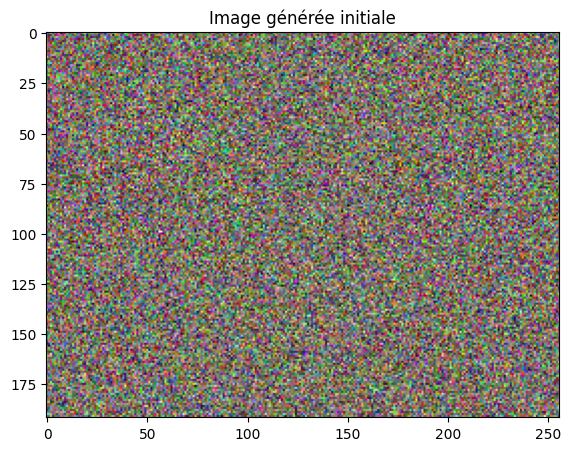

Step 1/20 | Loss: 39.662090 | Temps total: 0.40 min


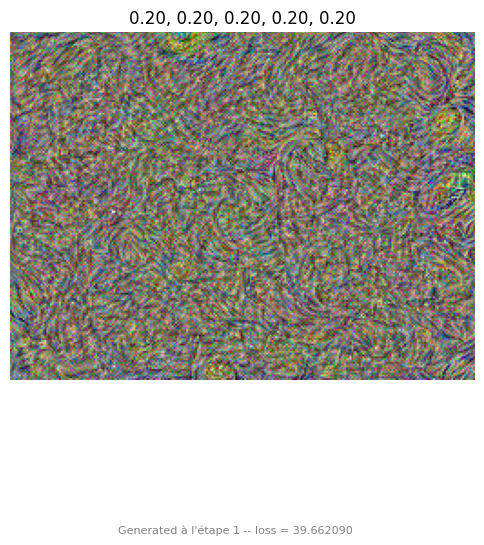

Step 2/20 | Loss: 26.912209 | Temps total: 0.75 min
Step 3/20 | Loss: 23.087225 | Temps total: 1.09 min
Step 4/20 | Loss: 21.194458 | Temps total: 1.41 min
Step 5/20 | Loss: 19.930576 | Temps total: 1.79 min


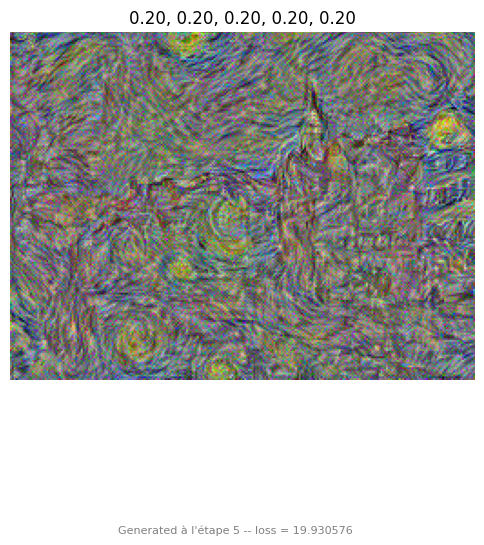

Step 6/20 | Loss: 19.077236 | Temps total: 2.13 min
Step 7/20 | Loss: 18.501072 | Temps total: 2.40 min
Step 8/20 | Loss: 18.056746 | Temps total: 2.66 min
Step 9/20 | Loss: 17.732576 | Temps total: 2.95 min
Step 10/20 | Loss: 17.480467 | Temps total: 3.21 min


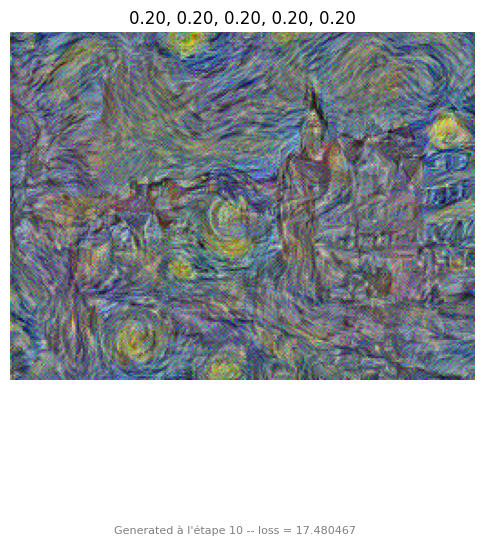

Step 11/20 | Loss: 17.294706 | Temps total: 3.47 min
Step 12/20 | Loss: 17.144583 | Temps total: 3.73 min
Step 13/20 | Loss: 17.027969 | Temps total: 4.08 min
Step 14/20 | Loss: 16.933104 | Temps total: 4.42 min
Step 15/20 | Loss: 16.850416 | Temps total: 4.80 min
Step 16/20 | Loss: 16.782778 | Temps total: 5.08 min
Step 17/20 | Loss: 16.727182 | Temps total: 5.35 min
Step 18/20 | Loss: 16.680952 | Temps total: 5.70 min
Step 19/20 | Loss: 16.639261 | Temps total: 6.11 min
Step 20/20 | Loss: 16.603148 | Temps total: 6.41 min


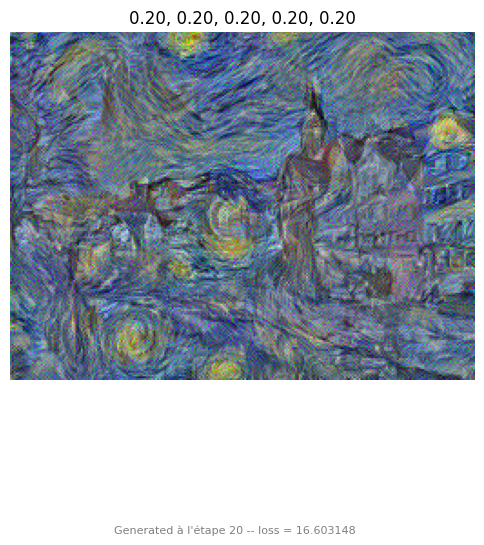

In [131]:
###### ----------------------------------------------- PIPELINE ----------------------------------------------- ######

print(" %%%%% Starting style transfer %%%%%%")

data_path = os.path.join(current_dir, "data")

base_output_dir = os.path.join(current_dir, "output_creation_image")
os.makedirs(base_output_dir, exist_ok=True)

# dossier pour cette image de sortie
output_path = os.path.join(base_output_dir, name_output)   
os.makedirs(output_path, exist_ok=True)

# initialisation de l'image générée
image_generated = torch.randn_like(content_image, requires_grad=True)

plot_image(image_generated, "Image générée initiale")

# Définition des extracteurs
content_extractor = VGGFeatures(vgg, layers=content_layer)
content_features = content_extractor(content_image)

style_extractor = VGGFeatures(vgg, layers=style_layers)
style_features = style_extractor(style_image)

# Gram matrices du style
style_grams = {l: gram_matrix(style_features[l]) for l in style_layers}

# création de l'optimiseur
global_optimizer = torch.optim.LBFGS([image_generated])

last_loss = None

def global_closure():
    global last_loss

    global_optimizer.zero_grad()

    # Calcul de la loss de contenu
    gen_content_features = content_extractor(image_generated)  # image générée → couches contenu
    loss_c = content_loss(
        gen_content_features[layer_idx],
        content_features[layer_idx]
    )

    # Calcul de la loss de style
    gen_style_features = style_extractor(image_generated)      # image générée → couches style
    loss_s = style_loss(
        gen_style_features,
        style_grams,
        style_layers,
        weights
    )

    λ_color = 1e-2
    # loss = alpha * loss_c + beta * loss_s 
    loss = alpha * loss_c + beta * loss_s + λ_color * color_loss(image_generated, style_image)

    loss.backward()
    last_loss = loss.item()

    return loss

start_total = time.time()

for i in range(num_steps):

    global_optimizer.step(global_closure)

    elapsed_total = time.time() - start_total

    print(
        f"Step {i+1}/{num_steps} | "
        f"Loss: {last_loss:.6f} | "
        f"Temps total: {elapsed_total/60:.2f} min"
    )

    if (i + 1) in display_steps:

        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(image_generated))       
        plt.axis('off')

        title_str = ", ".join([f"{w:.2f}" for w in weights])
        plt.title(title_str)

        plt.figtext(
            0.5, -0.05,
            f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}",
            ha="center", fontsize=8, color="gray"
        )

        # 💾 sauvegarde
        filename = f"{name_output}_etape{i+1:03d}.png"
        filepath = os.path.join(output_path, filename)     
        plt.savefig(filepath, bbox_inches="tight", dpi=150)

        plt.show()

    if last_loss is not None and last_loss < loss_threshold:
        print(f"Loss < {loss_threshold}, arrêt anticipé à l'étape {i+1}")

        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(image_generated))       
        plt.axis('off')

        title_str = ", ".join([f"{w:.2f}" for w in weights])
        plt.title(title_str)

        plt.figtext(
            0.5, -0.05,
            f"Generated à l'étape {i+1} -- loss = {last_loss:.6f}",
            ha="center", fontsize=8, color="gray"
        )

        filename = f"{name_output}_etape{i+1:03d}.png"
        filepath = os.path.join(output_path, filename)     
        plt.savefig(filepath, bbox_inches="tight", dpi=150)

        plt.show()
        break


### **4.3 Exemples de génération**

#### Certains mix ont bien fonctionné :

_**photo_canyon.jpg**_ + _**le_cri.jpg**_

_**photo_animal_montagne.jpg**_ + _**le_cri.jpg**_

_**photo_canal_du_midi.jpg**_ + _**monet_bassin_aux_nympheas.jpg**_

#### Cependant lorsque le style d'une image est trop chargé avec des motifs ou formes complexes comme _**mondrian.jpg**_ ou _**femme_qui_pleure.jpg**_ , le modèle peine à conserver le contenu de l'image de contenu.

_**photo_chat.jpg**_ + _**mondrian.jpg**_

_**photo_chat.jpg**_ + _**femme_qui_pleure.jpg**_

## **5. AdaIN : Adaptive Instance Normalization**

**Test d'implémentation d'une pipeline plus rapide pour la création d'image artistique à partir de l'article suivant :**

[Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://arxiv.org/abs/1703.06868)  
Xun Huang, Serge Belongie  
Department of Computer Science & Cornell Tech, Cornell University  



In [133]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

CONTENT_LAYER = 19
STYLE_LAYERS = [0, 5, 10, 19, 28]

encoder = VGGFeatures(vgg, STYLE_LAYERS)


def calc_mean_std(feat, eps=1e-5):
    B, C, H, W = feat.size()
    var = feat.view(B, C, -1).var(dim=2) + eps
    std = var.sqrt().view(B, C, 1, 1)
    mean = feat.view(B, C, -1).mean(dim=2).view(B, C, 1, 1)
    return mean, std

def adain(content_feat, style_feat):
    c_mean, c_std = calc_mean_std(content_feat)
    s_mean, s_std = calc_mean_std(style_feat)
    normalized = (content_feat - c_mean) / c_std
    return normalized * s_std + s_mean


class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3)
        )

decoder = Decoder().to(device)


# Télécharge decoder.pth depuis un repo PyTorch AdaIN (par ex. naoto0804/pytorch-AdaIN)
decoder.load_state_dict(torch.load("models/decoder.pth", map_location=device))
decoder.eval()


def adain_style_transfer(content, style, alpha=1.0):
    with torch.no_grad():
        content_feats = encoder(content)
        style_feats = encoder(style)

        c = content_feats[CONTENT_LAYER]
        s = style_feats[CONTENT_LAYER]

        t = adain(c, s)
        t = alpha * t + (1 - alpha) * c
        
        out = decoder(t)
        return out


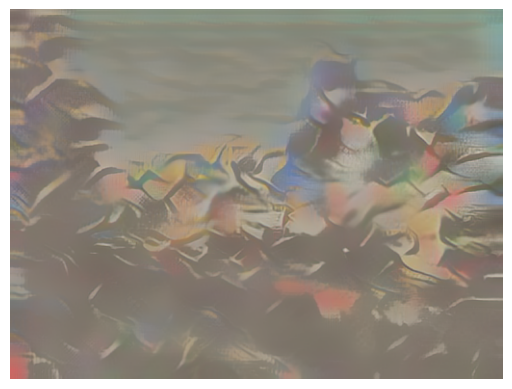

In [ ]:
content = load_image("photo_facade.jpg", 512)
style = load_image("nuit_etoilee.jpg", 512)

output = adain_style_transfer(content, style, alpha=1.0)
result_img = tensor_to_image(output)


plt.imshow(result_img)
plt.axis('off')
plt.show()